#### Example using DEMReg and SDO/AIA data
Here using synthetic SDO/AIA data for a single "pixel" generated from a Gaussian DEM 
Some quick tests of new approach/updated code

* 25-Apr-2020 IGH

In [1]:
# Import some of the stuff we will need
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import scipy.io as io
from dn2dem_pos import dn2dem_pos

import warnings
warnings.simplefilter('ignore')
matplotlib.rcParams['font.size'] = 16

# Load in the SSWIDL generated response functions
# Was produced by make_aiaresp_forpy.pro (can't escape sswidl that easily....)
trin=io.readsav('aia_tresp_en.dat')

# Get rid of the b in the string name (byte vs utf stuff....)
for i in np.arange(len(trin['channels'])):
    trin['channels'][i]=trin['channels'][i].decode("utf-8")

# Get the temperature response functions in the correct form for demreg
tresp_logt=np.array(trin['logt'])
nt=len(tresp_logt)
nf=len(trin['tr'][:])
trmatrix=np.zeros((nt,nf))
for i in range(0,nf):
    trmatrix[:,i]=trin['tr'][i]
matplotlib.rcParams['font.size'] = 16

# Setup some AIA colours
clrs=['darkgreen','darkcyan','gold','sienna','indianred','darkslateblue']

In [2]:
# For some DEM model (i.e. a Gaussian) produce the synthetic DN/s/px for each AIA channel
d1=4e22
m1=6.5
s1=0.15
root2pi=(2.*math.pi)**0.5
dem_mod=(d1/(root2pi*s1))*np.exp(-(tresp_logt-m1)**2/(2*s1**2))

# Now work out the DN/s/px
# For AIA responses all are dlogt=0.05
tresp_dlogt=np.full(nt,0.05)
tc_full=np.zeros([nt,nf])
for i in range(0,nf):
    tc_full[:,i]=dem_mod*trmatrix[:,i]*10**tresp_logt*np.log(10**tresp_dlogt)

dn_in=np.sum(tc_full,0)
print('dn_in: ',dn_in)

# And the associated uncertainty (no systematics)
gains=np.array([18.3,17.6,17.7,18.3,18.3,17.6])
dn2ph=gains*np.array([94,131,171,193,211,335])/3397.
rdnse=np.array([1.14,1.18,1.15,1.20,1.20,1.18])
# assume all obs were 2.9s long
dn0=dn_in*2.9
shotnoise=(dn2ph*dn0)**0.5/dn2ph/2.9
# error in DN/s/px
edn_in=(rdnse**2+shotnoise**2)**0.5 
print('edn_in: ',edn_in)

dn_in:  [  326.11015384   313.31711081  2663.51032443 11361.19771881
  8700.35613926  1208.36625448]
edn_in:  [14.94543537 12.67184957 32.12696433 61.39593307 51.38885685 15.53907416]


In [3]:
mint=5.7
maxt=7.1
dlogt=0.05
temps=10**np.arange(mint,maxt+dlogt,dlogt)
mlogt=([np.mean([(np.log10(temps[i])),np.log10((temps[i+1]))]) \
        for i in np.arange(0,len(temps)-1)])
dem0,edem0,elogt0,chisq0,dn_reg0=dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps,nmu=500)
dem0,edem0,elogt0,chisq0,dn_reg0=dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps,rgt_fact=0.1)
dem0,edem0,elogt0,chisq0,dn_reg0=dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps,rgt_fact=0.1,warn=False)
# dem0,edem0,elogt0,chisq0,dn_reg0=dn2dem_pos(-1*dn_in,edn_in,trmatrix,tresp_logt,temps,rgt_fact=0.1,warn=False)
# dem0,edem0,elogt0,chisq0,dn_reg0=dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps,rgt_fact=2.5)

# dem500,edem500,elogt500,chisq500,dn_reg500=dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps,nmu=5000)

# print(chisq0,chisq500)
# print(dem500)

Warning, rgt_fact should be > 1, for postivity loop to iterate properly.
Warning, rgt_fact should be > 1, for postivity loop to iterate properly.


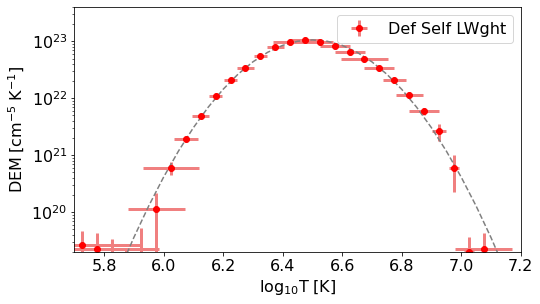

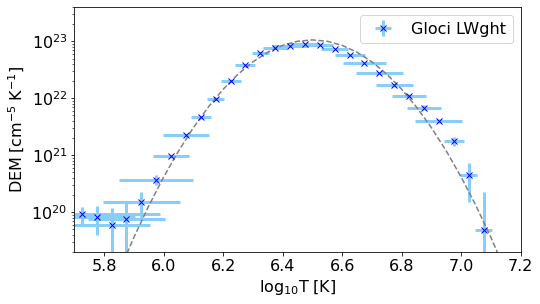

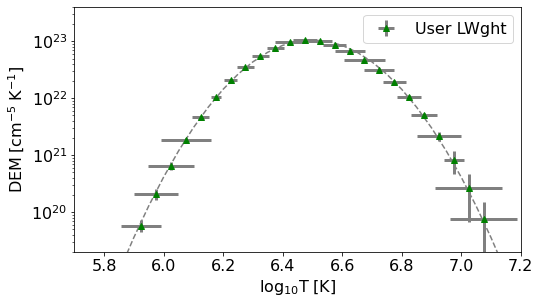

In [4]:
#  Setup the T binning for DEM solution
mint=5.7
maxt=7.1
dlogt=0.05
temps=10**np.arange(mint,maxt+dlogt,dlogt)
# Temperature bin mid-points for DEM plotting
mlogt=([np.mean([(np.log10(temps[i])),np.log10((temps[i+1]))]) \
        for i in np.arange(0,len(temps)-1)])

# Now work out the DEM - investigate 3 standard ways of running
# 1. Default - reg runs twice, 1st time to work out weight for constraint matrix, then regs with that
#         Best option if don't know what doing, hence its the default 
dem0,edem0,elogt0,chisq0,dn_reg0=dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps) #gloci=0 is default behaviour
# 2. EMloci - reg runs once, works out weight for constraint matrix as min of EM Loci, then regs with that
#        If some of your filters have a sharper T response (lines or X-ray obs) might be useful to try
dem1,edem1,elogt1,chisq1,dn_reg1=dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps,gloci=1)
# 3. User weight - reg runs once, user provide weight for constraint matrix L, then regs with that
#         If have an idea of what DEM might look like could try a rough form of it (though check vs 1, 2 above)
# As working with synthetic data from DEM model, could try weighting by this model, interp on output DEM T bins
demwght0=10**np.interp(mlogt,tresp_logt,np.log10(dem_mod))
dem2,edem2,elogt2,chisq2,dn_reg2=dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps,dem_norm0=demwght0/max(demwght0))

#  Plot it all
yr=[2e19,4e23]
xr=[5.7,7.2]#np.log10([min(temps),max(temps)])
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt,dem0,xerr=elogt0,yerr=edem0,fmt='or',\
             ecolor='lightcoral', elinewidth=3, capsize=0,label='Def Self LWght')
plt.plot(tresp_logt,dem_mod,'--',color='grey')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim(yr)
plt.xlim(xr)
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.legend()
plt.show()

#  Plot it all
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt,dem1,xerr=elogt1,yerr=edem1,fmt='xb',\
             ecolor='lightskyblue', elinewidth=3, capsize=0,label='Gloci LWght')
plt.plot(tresp_logt,dem_mod,'--',color='grey')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim(yr)
plt.xlim(xr)
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.legend()
plt.show()

#  Plot it all
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt,dem2,xerr=elogt2,yerr=edem2,fmt='^g',\
             ecolor='grey', elinewidth=3, capsize=0,label='User LWght')
plt.plot(tresp_logt,dem_mod,'--',color='grey')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim(yr)
plt.xlim(xr)
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.legend()
plt.show()


In [5]:
# #  How well did they actually do?
# print('Def Self, chisq: ',chisq0) # Not bad....
# print('Gloci, chisq: ',chisq1) # Worse of 3 but expected as just working with AIA filters here
# print('User, chisq: ',chisq2) # Know the answer so unsurprising this LWght gives best answer!

# print('Def Self: ',dn_reg0/dn_in)
# print('Gloci: ',dn_reg1/dn_in)
# print('User: ',dn_reg2/dn_in)

# fig,ax = plt.subplots(figsize=(8, 6))
# plt.scatter(dn_in,dn_reg0,color='red',marker='o',s=50,lw=2,label='DefSelf')
# plt.scatter(dn_in,dn_reg1,color='blue',marker='x',s=50,lw=2,label='Gloci')
# plt.scatter(dn_in,dn_reg2,color='green',marker='^',s=50,lw=2,label='USer')
# for i, lab in enumerate(trin['channels']):
#     ax.annotate(lab, (dn_in[i], 0.6*dn_reg0[i]),color=clrs[i],fontsize=12)
# plt.xlabel('DN_in')
# plt.ylabel('DN_reg')
# xyrang=[1e2,2e4]
# plt.plot(xyrang,xyrang,color='grey',ls='dashed')
# plt.ylim(xyrang)
# plt.xlim(xyrang)
# plt.rcParams.update({'font.size': 16})
# plt.yscale('log')
# plt.xscale('log')
# plt.legend()
# plt.show()

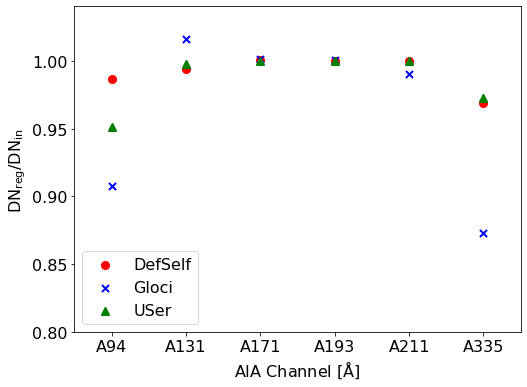

In [6]:
#  Or compare in terms of ratio
fig,ax = plt.subplots(figsize=(8, 6))
plt.scatter(np.arange(6),dn_reg0/dn_in,marker='o',color='red',s=50,lw=2,label='DefSelf')
plt.scatter(np.arange(6),dn_reg1/dn_in,marker='x',color='blue',s=50,lw=2,label='Gloci')
plt.scatter(np.arange(6),dn_reg2/dn_in,marker='^',color='green',s=50,lw=2,label='USer')
plt.ylim([0.80,1.04])
plt.xlim([-0.5,5.5])
plt.xticks(np.arange(6),trin['channels'])
plt.xlabel('AIA Channel [$\mathrm{\AA}$]')
plt.ylabel('DN$_\mathrm{reg}$/DN$_\mathrm{in}$')
plt.locator_params(axis='y', nbins=5)
plt.legend()
plt.show()

---

In [7]:
# # Now lets try making a 1D array (really 2D as t,f) from our synthetic pixel 
# # This could also be a map position-slice or pixel/region average changing with time

nt=12
# Only input data and error needs the extra dimensions here - TR resp and T binnings as before
dn_in2d=np.zeros([nt,nf])
edn_in2d=np.zeros([nt,nf])
for t in np.arange(nt):
# Giving some time dependance to our synthetic data so we can see the change in the DEMogram
# Obviously with real data you wouldn't need to do this
    dn_in2d[t,:]=dn_in*(1+(t*6.)/nt)
# Just use 10% for error as changed data - again with real data use the full error calculation
    edn_in2d[t,:]=0.1*dn_in
    
# Now do the DEMogram calculation    
dem1d,edem1d,elogt1d,chisq1d,dn_reg1d=dn2dem_pos(dn_in2d,edn_in2d,trmatrix,tresp_logt,temps)

# print('DN_reg: ',dn_reg1d[0,:])
# print('chisq: ',chisq1d[0])

In [8]:
# # Can plot t (or position) vs logT, producing a DEMogram
# fig,ax = plt.subplots(figsize=(8, 6))
# plt.imshow(dem1d.T,aspect='auto',origin='lower',norm=matplotlib.colors.LogNorm(vmin=1e21, vmax=1e24),\
#            extent=[0,nt-1,min(mlogt),max(mlogt)])
# plt.ylabel('$\mathrm{\log_{10}T\;[K]}$')
# plt.xlabel('Time')
# plt.colorbar(label='$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
# plt.show()

# #  A vertical slice of the below plot would give the standard DEM plot of DEM vs logT

In [9]:
# # Might help to subtract the DEM from the first time to see how things are changing

# dem1d_bs=(dem1d-dem1d[0,:])

# fig,ax = plt.subplots(figsize=(8, 6))
# plt.imshow(dem1d_bs.T,aspect='auto',origin='lower',\
#            # If subtraction then might be some -ve, so Log scale not best?
#            # norm=matplotlib.colors.Normalize(vmin=1e21, vmax=1e24),\
#            norm=matplotlib.colors.LogNorm(vmin=1e21, vmax=1e24),\
#            extent=[0,nt-1,min(mlogt),max(mlogt)])
# plt.ylabel('$\mathrm{\log_{10}T\;[K]}$')
# plt.xlabel('Time')
# plt.colorbar(label='$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
# plt.show()


In [10]:
# # Now lets try making a 2D array (really 3D as x,y,f) from our synthetic pixel 
# # to test speed of the code with a AIA "maps":
# # If lot's of data code automatically runs in parallel instead of serial

nx=20
ny=20
# Only input data and error needs the extra dimensions here - TR resp and T binnings as before
dn_in2d=np.zeros([nx,ny,nf])
edn_in2d=np.zeros([nx,ny,nf])


for y in np.arange(ny):
    for x in np.arange(nx):
        # Giving some x,y dependance to our synthetic data so we can see the change in the DEM maps
        # Obviously with real data you wouldn't need to do this
        dn_in2d[x,y,:]=dn_in *(1+(y*3./ny)+(x*4./nx))
        # Just use 10% for error as changed data - again with real data use the full error calculation
        edn_in2d[x,y,:]=0.1*dn_in 
        
#  Do slightly differnt binning for these DEMs
t_space=0.05
t_min=5.6
t_max=7.4
logtemps=np.linspace(t_min,t_max,num=int((t_max-t_min)/t_space)+1)
temps=10**logtemps   
        
# Now do the DEM maps calculation           
dem2d,edem2d,elogt2d,chisq2d,dn_reg2d=dn2dem_pos(dn_in2d,edn_in2d,trmatrix,tresp_logt,temps)


100%|██████████| 3.00/3.00 [00:01<00:00, 1.73DEM/s]


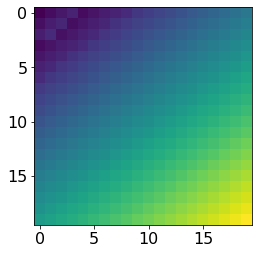

In [11]:
plt.imshow(dem2d[:,:,10])